# 1. Introduction

In this notebook, the IGANN-IT model is applied to 23 structured data sets and compared with interpretable and non-interpretable baselines.

# 2. Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from interpret.glassbox import ExplainableBoostingRegressor
from pathlib import Path
import importlib



%load_ext autoreload
%autoreload 2

In [2]:
data_path = "/Users/maximilianveitl/data/shared"
seed = 42

# 3. Overview Datasets

In [3]:
import yaml

with open("/Users/maximilianveitl/workspace/master/datasets-main/datasets.yml", "r") as file:
    data = yaml.safe_load(file)

dataset_rows = []
for name, cfg in data["datasets"].items():
    num_features = cfg.get("numerical_features", [])
    cat_features = cfg.get("categorical_features", [])

    if len(cat_features) >= 1:
        row = {
            "name": name,
            "file_name": cfg.get("file_name"),
            "task_type": cfg.get("task_type"),
            "n_num_features": len(num_features),
            "n_cat_features": len(cat_features),
            "target": cfg.get("target"),
            "separator": cfg.get("separator", ","),
            "folder_name": cfg.get("folder_name", "shared"),
            "num_features": num_features,
            "cat_features": cat_features
        }
        dataset_rows.append(row)
        
df_overview = pd.DataFrame(dataset_rows)

df_overview.head(23)

,name,file_name,task_type,n_num_features,n_cat_features,target,separator,folder_name,num_features,cat_features
0,stroke,healthcare-dataset-stroke-data.csv,binary,3,7,stroke,",",shared,"[age, avg_glucose_level, bmi]","[gender, hypertension, heart_disease, ever_mar..."
1,churn,WA_Fn-UseC_-Telco-Customer-Churn.csv,binary,3,16,Churn,",",shared,"[tenure, MonthlyCharges, TotalCharges]","[gender, SeniorCitizen, Partner, Dependents, P..."
2,fico,fico_heloc_dataset_v1.csv,binary,21,2,RiskPerformance,",",shared,"[ExternalRiskEstimate, MSinceOldestTradeOpen, ...","[MaxDelq2PublicRecLast12M, MaxDelqEver]"
3,bank,bank-full.csv,binary,6,9,y,;,shared,"[age, balance, day, campaign, pdays, previous]","[job, marital, education, default, housing, lo..."
4,adult,adult_census_income.csv,binary,6,8,income,",",shared,"[age, fnlwgt, education.num, capital.gain, cap...","[workclass, education, marital.status, occupat..."
5,airline,airline_train.csv,binary,18,4,satisfaction,",",shared,"[Age, Flight Distance, Inflight wifi service, ...","[Gender, Customer Type, Type of Travel, Class]"
6,college,college_data.csv,binary,4,6,will_go_to_college,",",shared,"[parent_age, parent_salary, house_area, averag...","[type_school, school_accreditation, gender, in..."
7,weather,weatherAUS.csv,binary,16,5,RainTomorrow,",",shared,"[MinTemp, MaxTemp, Rainfall, Evaporation, Suns...","[Location, WindGustDir, WindDir9am, WindDir3pm..."
8,compas,compas-scores-two-years.csv,binary,7,5,two_year_recid,",",shared,"[age, juv_fel_count, juv_misd_count, juv_other...","[sex, age_cat, race, c_charge_degree, c_charge..."
9,car,car.data,regression,13,11,price,",",shared,"[wheel-base, length, width, height, curb-weigh...","[symboling, make, fuel-type, aspiration, num-o..."


# 4. Experiment

## 4.1 Regression Tasks

In [4]:
results = pd.DataFrame(columns=["model", "dataset", "mse", "r2"])

In [7]:
# model Lasso (one-hot encoding needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
    X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Models
    model = Lasso(alpha=0.01)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.loc[len(results)] = {
        'model': 'Lasso',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2}

In [8]:
# DecisionTree, RandomForest, XGBoost (OrdinalEncoder needed)
datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=seed),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=seed),
}

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and ordinal encoding categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_cat = encoder.fit_transform(X_train_cat)
    X_test_cat = encoder.transform(X_test_cat)

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Models
    for name, model in models.items():
        print(f"Training {name} on {folder_name} dataset...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 9. Evaluate Models
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.loc[len(results)] = {
            'model': name,
            'dataset': folder_name,
            'mse': mse,
            'r2': r2}

Training DecisionTree on student dataset...
Training RandomForest on student dataset...
Training DecisionTree on bike dataset...
Training RandomForest on bike dataset...
Training DecisionTree on insurance dataset...
Training RandomForest on insurance dataset...
Training DecisionTree on crab dataset...
Training RandomForest on crab dataset...
Training DecisionTree on diamond dataset...
Training RandomForest on diamond dataset...
Training DecisionTree on productivity dataset...
Training RandomForest on productivity dataset...
Training DecisionTree on diabetes dataset...
Training RandomForest on diabetes dataset...


In [9]:
# EBM

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    model = ExplainableBoostingRegressor(interactions=1, max_bins=255, learning_rate=0.01, max_leaves=3, min_samples_leaf=2, random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.loc[len(results)] = {
        'model': 'EBM',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2}

In [5]:
# IGANN on student, bike, insurance, crab, diamond, productivity, diabetes
data = pd.read_csv('/Users/maximilianveitl/data/shared/student/student-por.csv', sep=';')
X = data.drop(columns='G3')
y = data['G3']

# 1. Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# 2. Split features into numerical and categorical
row = df_overview[df_overview["name"] == "student"].iloc[0]
X_train_num = X_train[row["num_features"]]
X_train_cat = X_train[row["cat_features"]]
X_test_num = X_test[row["num_features"]]
X_test_cat = X_test[row["cat_features"]]

# 3. Replace empty strings and other chars in numerical features with np.nan
X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

# 4. Correct data types
X_train_num = X_train_num.astype(float)
X_test_num = X_test_num.astype(float)
X_train_cat = X_train_cat.astype(str)
X_test_cat = X_test_cat.astype(str)

# 5. Impute missing values
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_num = imputer_num.fit_transform(X_train_num)
X_train_cat = imputer_cat.fit_transform(X_train_cat)
X_test_num = imputer_num.transform(X_test_num)
X_test_cat = imputer_cat.transform(X_test_cat)

# 6. Scale numerical features and target and one-hot encode categorical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

# 7. Concatenate numerical and categorical features
X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)


In [8]:
y_train

213   -0.245638
43    -0.554113
42     0.988264
73     0.679789
494   -0.862589
         ...   
71    -0.554113
106   -0.554113
270    0.988264
435   -0.554113
102    0.062838
Name: G3, Length: 486, dtype: float64

In [7]:
import sys
import importlib

# Füge den Pfad zum alternativen Ordner hinzu
sys.path.insert(0, "/Users/maximilianveitl/workspace/master/Ursprung")

# Jetzt kannst du das alternative igann importieren
import igann
importlib.reload(igann)  # optional, wenn du sicherstellen willst, dass es neu geladen wird
from igann import IGANN

# (optional) Den Pfad wieder entfernen, damit es keine Seiteneffekte gibt
sys.path.pop(0)


'/Users/maximilianveitl/workspace/master/Ursprung'

In [8]:
model = IGANN(task='regression', n_hid=10)
model.fit(X_train, y_train)

: 

In [3]:
from igann import IGANN

In [4]:
import igann
print("Modulpfad:", igann.__file__)


Modulpfad: /Users/maximilianveitl/workspace/master/masterarbeit/igann-it/igann/__init__.py


In [6]:
# IGANN

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    print(f"Training IGANN on {folder_name} dataset...")
    model = IGANN(task="regression", n_hid=10, interaction_detection_method='rulefit')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.loc[len(results)] = {
        'model': 'IGANN',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2}

Training IGANN on student dataset...


: 

In [25]:
# Modul aus dem Cache löschen
if "igann" in sys.modules:
    del sys.modules["igann"]

# Danach normal importieren
import igann
importlib.reload(igann)
from igann import IGANN


In [20]:
sys.path

['/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python39.zip',
 '/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9',
 '/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/lib-dynload',
 '',
 '/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/site-packages',
 '/Users/maximilianveitl/opt/anaconda3/envs/maenv/lib/python3.9/site-packages/setuptools/_vendor']

In [26]:
# IGANN

datasets_filtered = df_overview[(df_overview["task_type"] == "regression") & (df_overview["name"] != "car")]

for idx, row in datasets_filtered.iterrows():
    # load data
    file_name = row["file_name"]
    separator = row["separator"]
    folder_name = row["name"]
    target = row["target"]
    file_path = f"{data_path}/{folder_name}/{file_name}"

    data = pd.read_csv(file_path, sep=separator)
    
    X = data.drop(columns=target)
    y = data[target]

    # Preprocessing
    # 1. Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    # 2. Split features into numerical and categorical
    X_train_num = X_train[row["num_features"]]
    X_train_cat = X_train[row["cat_features"]]
    X_test_num = X_test[row["num_features"]]
    X_test_cat = X_test[row["cat_features"]]

    # 3. Replace empty strings and other chars in numerical features with np.nan
    X_train_num = X_train_num.replace({"": np.nan, " ": np.nan, "?": np.nan})
    X_test_num = X_test_num.replace({"": np.nan, " ": np.nan, "?": np.nan})

    # 4. Correct data types
    X_train_num = X_train_num.astype(float)
    X_test_num = X_test_num.astype(float)
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)

    # 5. Impute missing values
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_num = imputer_num.fit_transform(X_train_num)
    X_train_cat = imputer_cat.fit_transform(X_train_cat)
    X_test_num = imputer_num.transform(X_test_num)
    X_test_cat = imputer_cat.transform(X_test_cat)

    # 6. Scale numerical features and target and one-hot encode categorical features
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # 7. Concatenate numerical and categorical features
    X_train_num = pd.DataFrame(X_train_num, columns=row["num_features"])
    X_test_num = pd.DataFrame(X_test_num, columns=row["num_features"])
    X_train_cat = pd.DataFrame(X_train_cat, columns=row["cat_features"])
    X_test_cat = pd.DataFrame(X_test_cat, columns=row["cat_features"])

    X_train = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat], axis=1)

    # 8. Train Model
    print(f"Training IGANN on {folder_name} dataset...")
    model = IGANN(task="regression", n_hid=10, interaction_detection_method="rulefit")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 9. Evaluate Model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.loc[len(results)] = {
        'model': 'IGANN',
        'dataset': folder_name,
        'mse': mse,
        'r2': r2}

Training IGANN on student dataset...


TypeError: __init__() got an unexpected keyword argument 'interaction_detection_method'

In [12]:
results

,model,dataset,mse,r2
0,IGANN,student,0.739720,0.228850
1,IGANN,bike,0.393025,0.594905
2,IGANN,insurance,0.250985,0.758423
3,IGANN,crab,0.432301,0.541041
4,IGANN,diamond,0.073215,0.923816
5,IGANN,productivity,0.653038,0.276280
6,IGANN,diabetes,0.466449,0.488570


In [ ]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_train

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,-0.620001,1.361000,1.605438,-0.761953,0.121101,-0.386572,0.083593,1.697584,-1.029328,-0.541945,...,True,False,False,True,False,False,True,True,True,False
1,-1.427831,-0.433969,-0.261172,-0.761953,-1.105046,-0.386572,1.125291,0.763240,-1.875780,-0.541945,...,False,False,True,True,False,False,True,True,True,False
2,-1.427831,1.361000,1.605438,-0.761953,0.121101,-0.386572,0.083593,-0.171104,-0.182875,-0.541945,...,False,False,False,True,False,True,True,True,True,False
3,-0.620001,0.463516,-1.194476,-0.761953,-1.105046,-0.386572,1.125291,-0.171104,-1.029328,0.507398,...,True,False,False,False,False,True,True,True,False,False
4,-0.620001,-1.331453,-0.261172,-0.761953,0.121101,-0.386572,0.083593,0.763240,1.510029,-0.541945,...,True,False,False,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,-1.427831,1.361000,-0.261172,-0.761953,2.573396,-0.386572,-0.958105,-0.171104,-0.182875,-0.541945,...,True,False,False,False,False,False,True,True,True,False
482,-1.427831,-0.433969,-0.261172,-0.761953,2.573396,-0.386572,1.125291,-2.039793,-1.029328,-0.541945,...,True,False,True,True,False,False,True,True,True,False
483,-0.620001,1.361000,1.605438,-0.761953,-1.105046,-0.386572,1.125291,-0.171104,-1.029328,-0.541945,...,True,False,False,False,True,True,True,True,True,False
484,-1.427831,-1.331453,-1.194476,0.537377,0.121101,-0.386572,1.125291,0.763240,-0.182875,-0.541945,...,False,False,False,True,False,False,True,True,True,False


In [ ]:
results

[{'model': 'Lasso', 'mse': 0.5993587210887381, 'r2': 0.38223567929454216},
 {'model': 'DecisionTree',
  'mse': 0.3462871847723765,
  'r2': 0.6430787440928218},
 {'model': 'EBM', 'mse': 0.08534065293646934, 'r2': 0.9120386362375918},
 {'model': 'RandomForest',
  'mse': 0.056057184849344334,
  'r2': 0.9422213651013375},
 {'model': 'IGANN', 'mse': 0.39302520209500114, 'r2': 0.5949054573673312},
 {'model': 'IGANN-IT', 'mse': 0.3705377880791544, 'r2': 0.6180834333525429}]

In [ ]:
model = IGANN(task='regression', n_hid=10, interaction_detection_method='rulefit')

In [ ]:
# unique values in body-style column in X_train
X_train.columns

Index(['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size',
       'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
       'city-mpg', 'highway-mpg', 'symboling', 'make', 'fuel-type',
       'aspiration', 'num-of-doors', 'body-style', 'drive-wheels',
       'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'],
      dtype='object')

In [1]:
| Kategorie               | Metriken                                 |
| ----------------------- | ---------------------------------------- |
| **Performance**         | Accuracy, F1, AUC, RMSE (bei Regression) |
| **Interpretierbarkeit** | Anzahl Regeln, Sparsity, Feature-Nutzung |
| **Rechenzeit**          | Training / Inferenzzeit                  |


SyntaxError: invalid syntax (3539944620.py, line 1)

In [ ]:
X_num.describe()

,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,10.164279,25.179104,30.686567
std,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,4.004965,6.423220,6.815150
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,8.600000,19.000000,25.000000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,9.400000,30.000000,34.000000
max,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [ ]:
X_num = scaler.fit_transform(X_num)
X_num

ValueError: could not convert string to float: '?'

## 4.2 Classification Tasks

In [ ]:
model = IGANN(task='classification', n_hid=10, interaction_detection_method='rulefit')

# 5. Results Summary

Pandas-Tabelle aller Scores (Zeilen = Datensätze, Spalten = Modelle & Metriken)

Balkendiagramme, Heatmaps oder Boxplots

🧠 6. Interpretierbarkeit vergleichen
Sparsity oder Regelanzahl je Modell

Optional: Visualisierung einzelner Modelle

Optional: Human Readability Score oder qualitative Einschätzung

📌 7. Fazit / Beobachtungen (Markdown)
Wann performt IGANN-IT besonders gut?

Wo ist der Kompromiss zwischen Performance und Interpretierbarkeit am besten?

Vergleich zu anderen interpretablen Modellen (z. B. LR, DT)

# XXX. Setup IGANN Model

# 3. Ames Housing Dataset

## 3.1 Load Data

In [5]:
from sklearn.datasets import fetch_openml

data = fetch_openml(data_id=42165, as_frame=True)
df = data.frame

# Feature-Auswahl
selected_features = ['LotArea', 'OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea',
                     'Neighborhood', 'BldgType', 'HouseStyle', 'CentralAir', 'ExterQual']

X = df[selected_features]
y = df['SalePrice']

X.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood,BldgType,HouseStyle,CentralAir,ExterQual
0,8450,7,2003,856,1710,CollgCr,1Fam,2Story,Y,Gd
1,9600,6,1976,1262,1262,Veenker,1Fam,1Story,Y,TA
2,11250,7,2001,920,1786,CollgCr,1Fam,2Story,Y,Gd
3,9550,7,1915,961,1717,Crawfor,1Fam,2Story,Y,TA
4,14260,8,2000,1145,2198,NoRidge,1Fam,2Story,Y,Gd


In [6]:
# scale data
scaler = StandardScaler()
X_num = scaler.fit_transform(X.iloc[:,:5])
X = pd.concat([pd.DataFrame(X_num, columns=X.columns[:5]), X.iloc[:,5:]], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y.mean()) / y.std()

X.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood,BldgType,HouseStyle,CentralAir,ExterQual
0,-0.207142,0.651479,1.050994,-0.793434,0.370333,CollgCr,1Fam,2Story,Y,Gd
1,-0.091886,-0.071836,0.156734,0.257140,-0.482512,Veenker,1Fam,1Story,Y,TA
2,0.073480,0.651479,0.984752,-0.627826,0.515013,CollgCr,1Fam,2Story,Y,Gd
3,-0.096897,0.651479,-1.863632,-0.521734,0.383659,Crawfor,1Fam,2Story,Y,TA
4,0.375148,1.374795,0.951632,-0.045611,1.299326,NoRidge,1Fam,2Story,Y,Gd


## 3.2 Train Model

In [ ]:
model.grouped_encoded_features

[[5, 6, 7, 8],
 [9],
 [10, 11, 12],
 [13, 14, 15, 16, 17, 18, 19],
 [20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43]]

In [7]:
model = IGANN(task='regression', n_hid=10, interaction_detection_method='rulefit')

In [8]:
model.fit(X, y)

: 

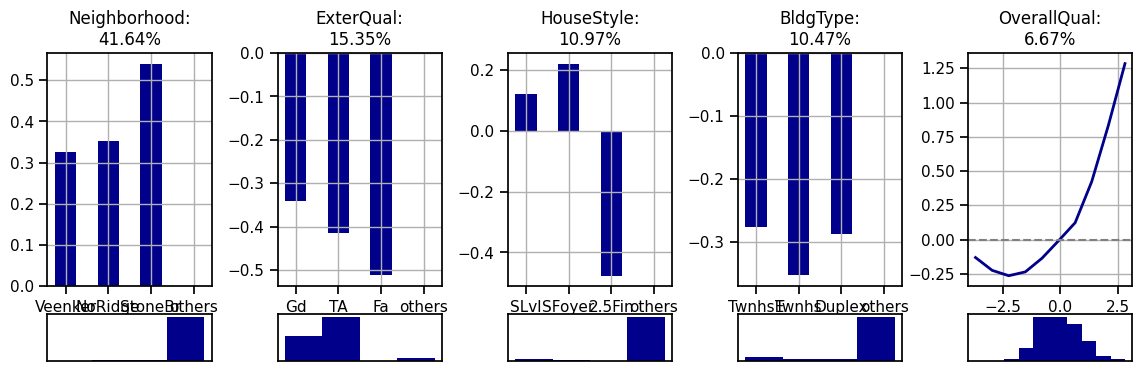

In [ ]:
model.plot_single()

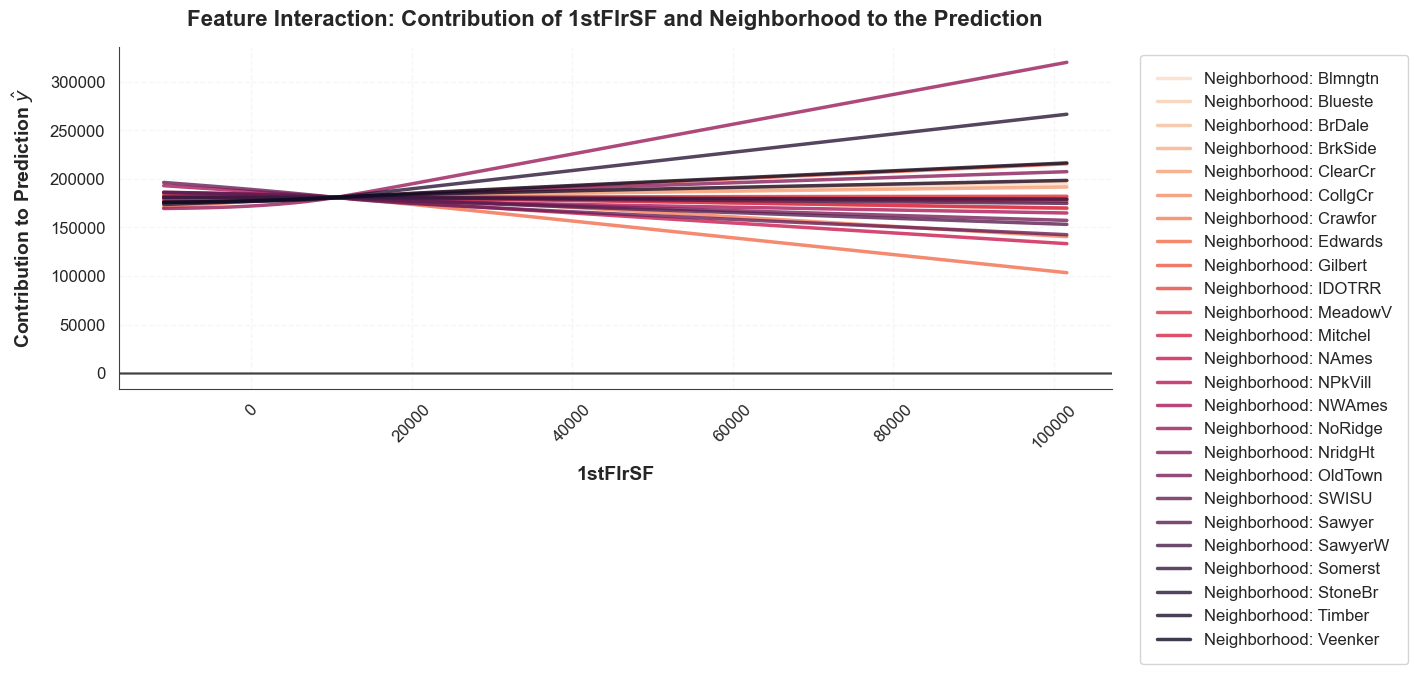

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=False)

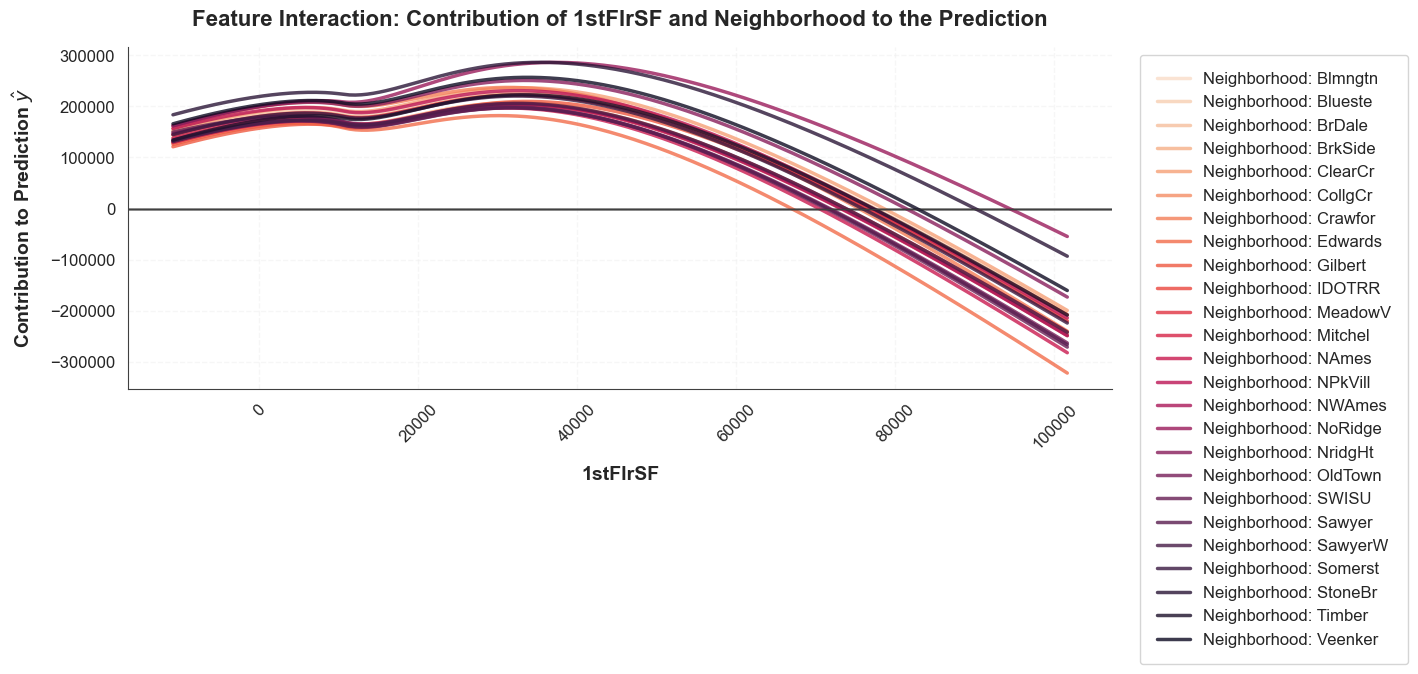

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=True)

## 3.3 Model Evaluation

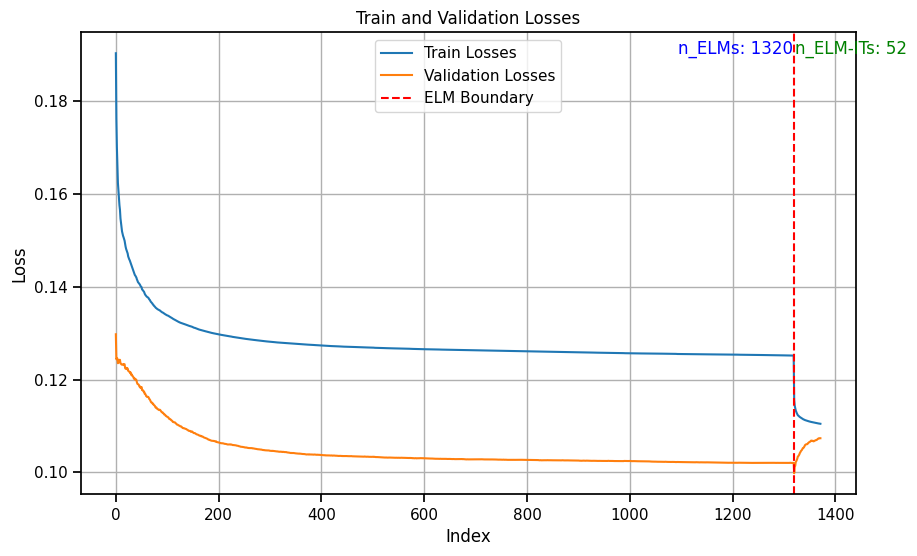

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

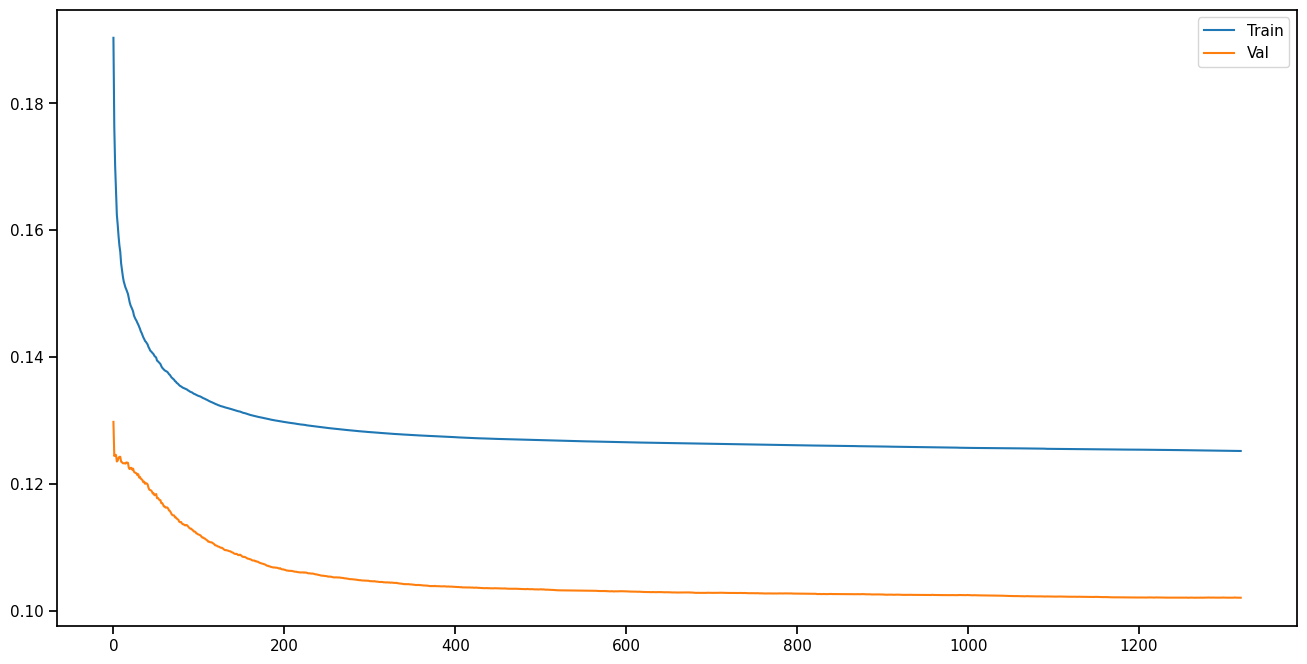

In [ ]:
model.plot_learning()

## 3.3 Infos zu Model

### 3.3.1 Alle Attribute

In [ ]:
ignored_attributes = ["regressor_predictions", "unique", "hist", "y_hats", 'y_hats_val', "regressors", "regressors_it", "train_losses", "train_losses_it", "val_losses_it", "val_losses", "regressor_predictions_it"]

for attr, value in vars(model).items():
    if attr not in ignored_attributes:
        print(f"{attr}: {value}")

task: regression
n_hid: 10
elm_scale: 1
elm_alpha: 1
init_reg: 1
act: elu
n_estimators: 5000
early_stopping: 50
sparse: 0
device: cpu
random_state: 1
optimize_threshold: False
verbose: 0
interaction_detection_method: dt
boost_rate: 0.1
target_remapped_flag: False
init_classifier: Lasso(alpha=1)
criterion: MSELoss()
boosting_rates: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

# 4. Synthetic Dataset

## 4.1 Create Data

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate numeric variables
x1 = np.random.uniform(0, 10, n_samples)  # Continuous variable 1
x2 = np.random.uniform(0, 5, n_samples)   # Continuous variable 2

# Generate categorical variables
categories = ['A', 'B', 'C', 'D']
x3 = np.random.choice(categories, size=n_samples, p=[0.4, 0.3, 0.1, 0.2])  # Categorical variable 1
x4 = np.random.choice(['X', 'Y'], size=n_samples, p=[0.5, 0.5])  # Categorical variable 2

# Create interaction effect: x1 interacts with x3
interaction_effect = np.zeros(n_samples)
for i, cat in enumerate(categories):
    interaction_effect[x3 == cat] = x1[x3 == cat] * (i + 1)

# Generate the target variable (y) with noise
y = (
    2 * x1 +                   # Linear effect of x1
    3 * np.sin(x2) +           # Non-linear effect of x2
    interaction_effect +       # Interaction effect between x1 and x3
    np.random.normal(0, 1, n_samples)  # Random noise
)

# Combine into a DataFrame
X = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
})


# Display the first few rows of the dataset
print(X.head())


         x1        x2 x3 x4
0  3.745401  0.925665  A  Y
1  9.507143  2.709505  A  Y
2  7.319939  4.364729  D  X
3  5.986585  3.661124  A  Y
4  1.560186  4.032806  A  Y


## 4.2 Scale Data

In [ ]:
# scale data
scaler = StandardScaler()
X_num = scaler.fit_transform(X.iloc[:,:2])
X = pd.concat([pd.DataFrame(X_num, columns=X.columns[:2]), X.iloc[:,2:]], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

X.head()

,x1,x2,x3,x4
0,-0.396301,-1.102179,A,Y
1,1.576957,0.119447,A,Y
2,0.827893,1.252992,D,X
3,0.371251,0.771143,A,Y
4,-1.144685,1.025681,A,Y


In [ ]:
model.fit(X, y)

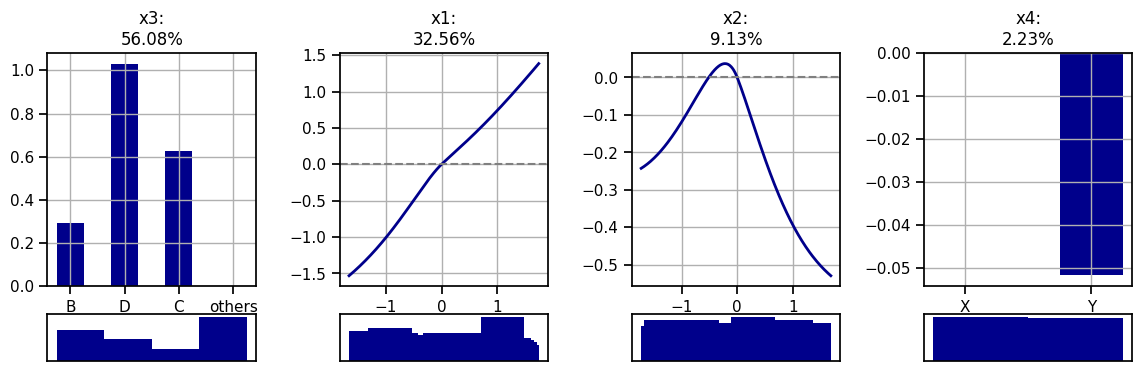

In [ ]:
model.plot_single(show_n=4)

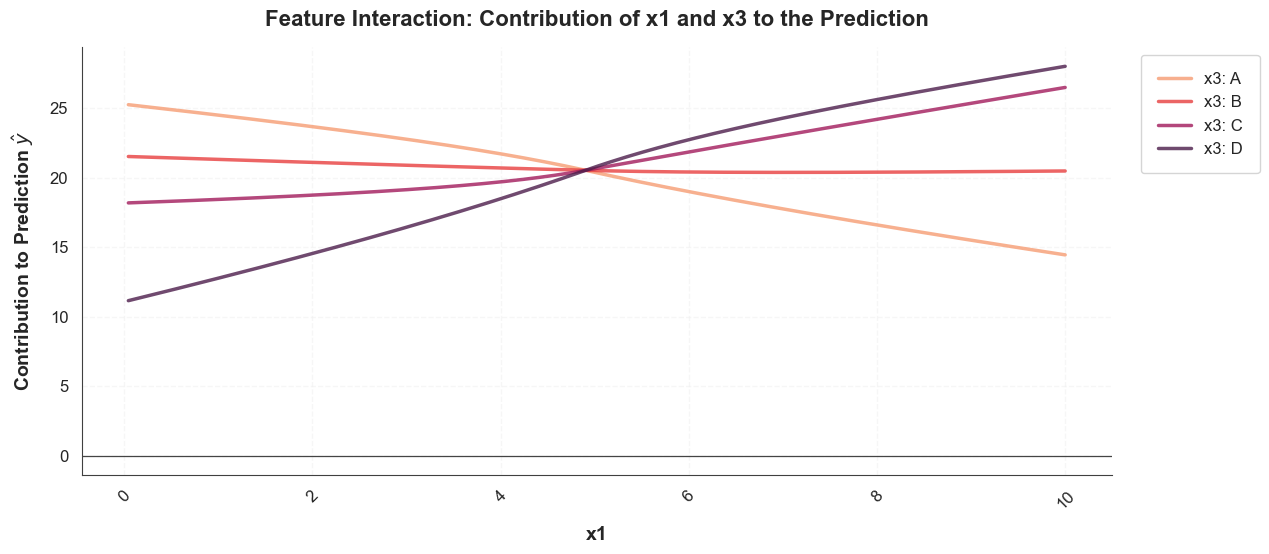

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=False)

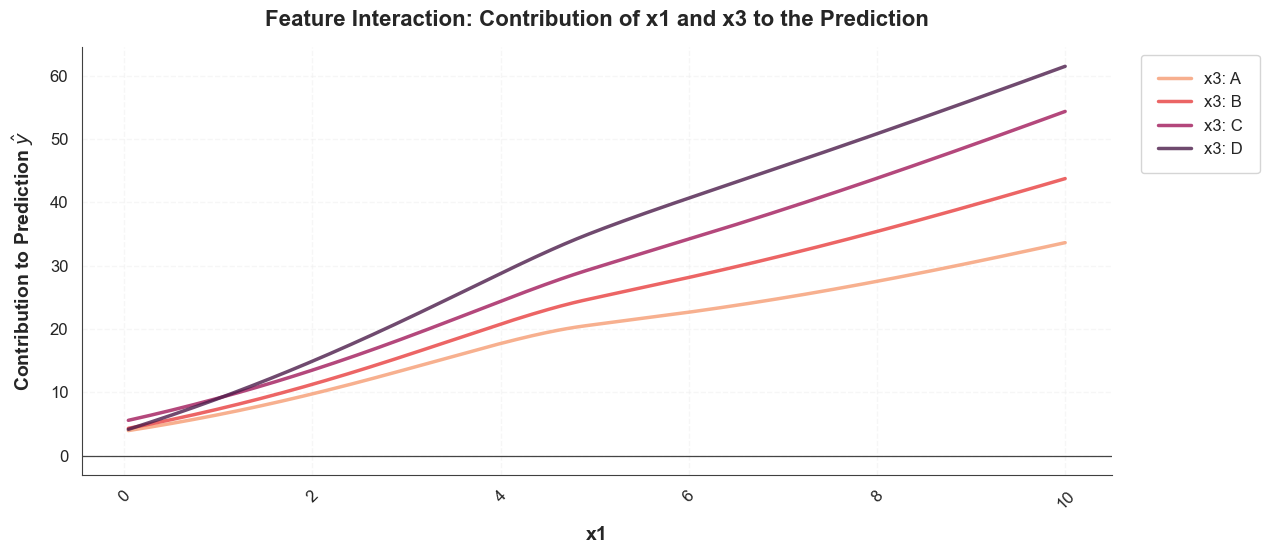

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=True)

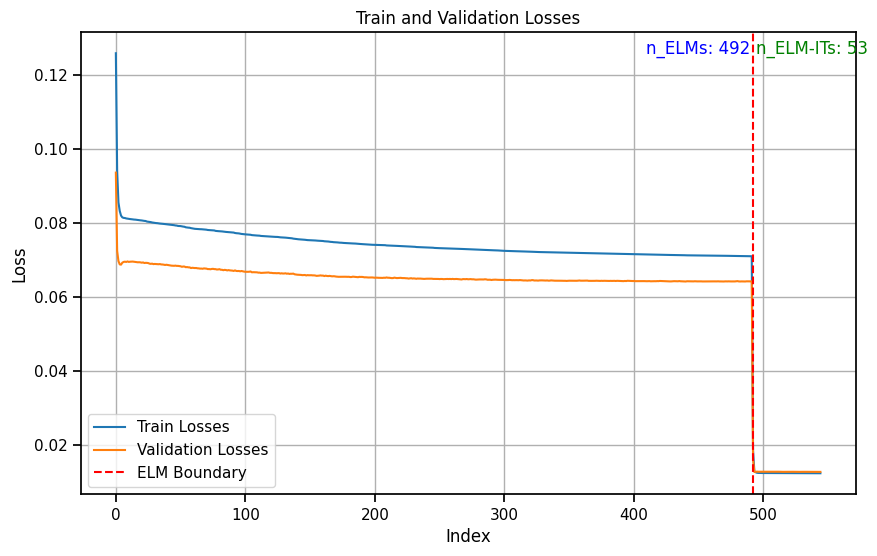

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

# 5. catelematic13


## 5.1 Load Data

In [ ]:
cat = pd.read_csv('/Users/maximilianveitl/Documents/Studium/Master/3. Semester/Masterarbeit/catelematic13.csv')
cat.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609,Urban,6213.71,25,...,1,0,0,3,1,0,0,0,1,5100.171753
1,182,44,Female,3,Married,Commute,575,Urban,12427.42,20,...,58,24,11,1099,615,219,101,40,1,883.554840
2,184,48,Female,6,Married,Commute,847,Urban,12427.42,14,...,0,0,0,0,0,0,0,0,0,0.000000
3,183,71,Male,6,Married,Private,842,Urban,6213.71,43,...,0,0,0,0,0,0,0,0,0,0.000000
4,183,84,Male,10,Married,Private,856,Urban,6213.71,65,...,2,0,0,325,111,18,4,2,0,0.000000


In [ ]:
cat.shape

(100000, 52)

In [ ]:
X = cat[['Duration', 'Insured.age', 'Insured.sex', 'Car.age', 'Car.use', 'Credit.score', 'Region', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']]
y = cat['AMT_Claim']
#y = cat['NB_Claim']

NameError: name 'cat' is not defined

In [ ]:
# scale data
scaler = StandardScaler()
continuous_features = ['Duration', 'Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven', 'Total.miles.driven', 'Pct.drive.2hrs', 'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend', 'Pct.drive.rush.am', 'Pct.drive.rush.pm', 'Avgdays.week', 'Accel.06miles', 'Accel.14miles', 'Brake.06miles', 'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity12', 'Right.turn.intensity08', 'Right.turn.intensity12']
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

## 5.2 Model

In [ ]:
model.fit(X, y)

## 5.3 Visualization

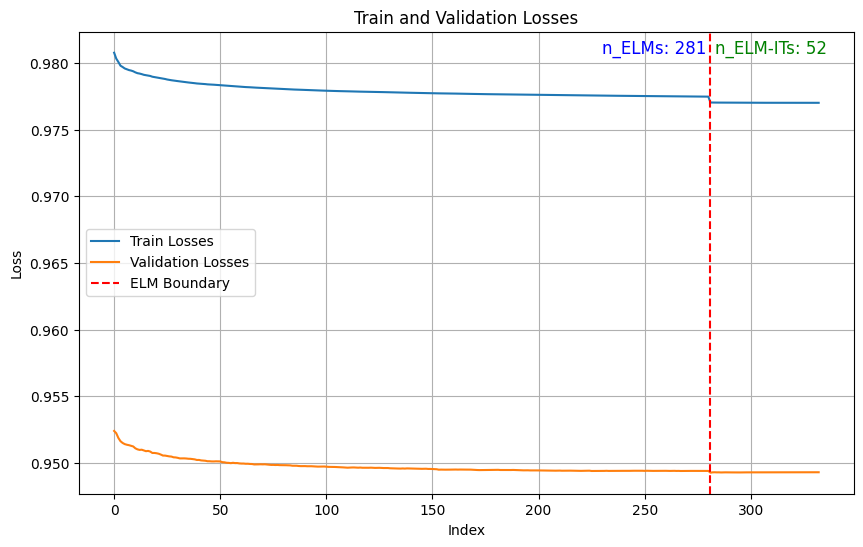

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

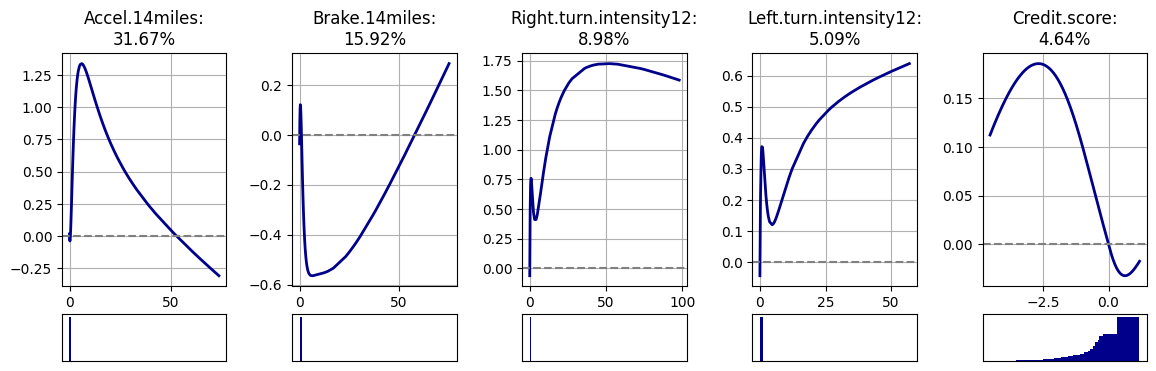

In [ ]:
model.plot_single()

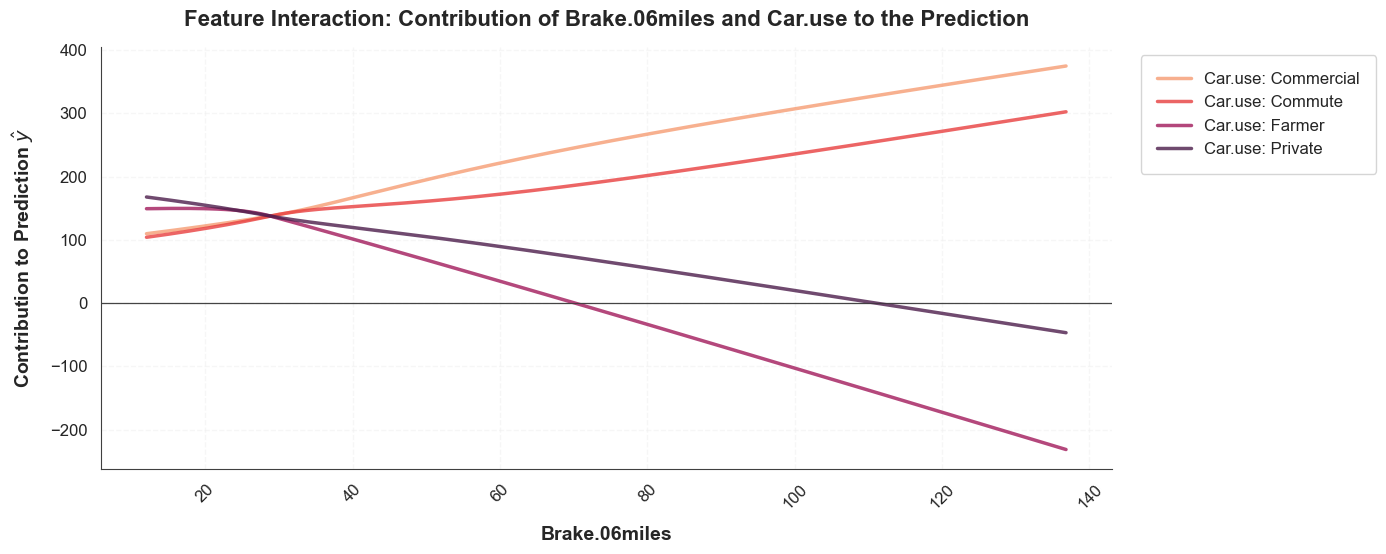

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=False)

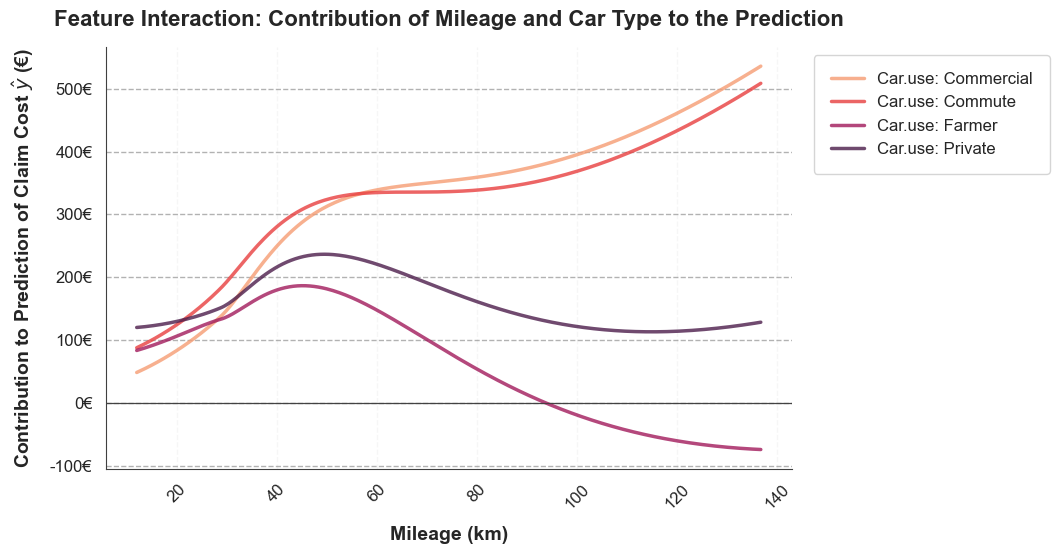

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=True)

In [ ]:
data

[{'name': 'category 1',
  'x': [5036.7421875,
   5685.84375,
   6334.9453125,
   6984.0546875,
   7633.15625,
   8282.2578125,
   8931.3671875,
   9580.46875,
   10229.5703125,
   10878.671875,
   11527.78125,
   12176.8828125,
   12825.984375,
   13475.0859375,
   14124.1875,
   14773.296875,
   15422.3984375,
   16071.5078125,
   16720.609375,
   17369.7109375,
   18018.8125,
   18667.9140625,
   19317.015625,
   19966.125,
   20615.234375,
   21264.328125,
   21913.4375,
   22562.5390625,
   23211.640625,
   23860.7421875,
   24509.8515625,
   25158.953125,
   25808.0546875,
   26457.15625,
   27106.2578125,
   27755.3671875,
   28404.4765625,
   29053.578125,
   29702.6796875,
   30351.78125,
   31000.8828125,
   31649.984375,
   32299.09375,
   32948.1953125,
   33597.3046875,
   34246.3984375,
   34895.5078125,
   35544.609375,
   36193.71484375,
   36842.81640625,
   37491.91796875,
   38141.0234375,
   38790.125,
   39439.234375,
   40088.33203125,
   40737.44140625,
   41386.5

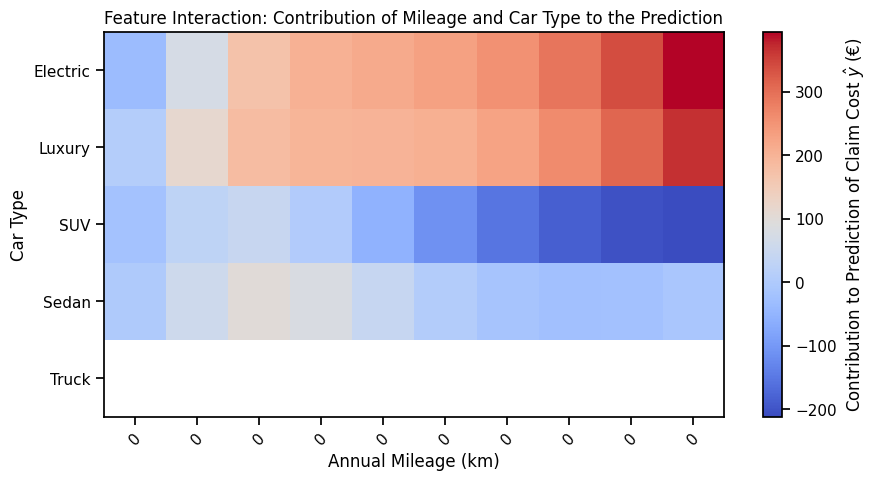

In [ ]:
shape_fun = model.get_it_shape_functions_as_dict(scaler=scaler, y_mean=0, y_std=y_std)
data = shape_fun
unique_x_values = sorted(set([x for category in shape_fun for x in category['x']]))

# devide x-Values in bins
num_bins = 10
bins = np.linspace(min(unique_x_values), max(unique_x_values), num_bins + 1)

#categories = [category['name'] for category in shape_fun]
categories = ['Electric', 'Luxury', 'SUV', 'Sedan', 'Truck']

# create matrix for binned data
heatmap_data_binned = np.full((len(categories), num_bins), np.nan)
for i, category in enumerate(data):
    for x_val, y_val in zip(category['x'], category['y_incl_univ']):
        bin_index = np.digitize(x_val, bins) - 1  # Bin-Index bestimmen
        if 0 <= bin_index < num_bins:
            if np.isnan(heatmap_data_binned[i, bin_index]):
                heatmap_data_binned[i, bin_index] = y_val
            else:
                heatmap_data_binned[i, bin_index] = (heatmap_data_binned[i, bin_index] + y_val) / 2

bin_labels = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

df_heatmap_binned = pd.DataFrame(heatmap_data_binned, index=categories, columns=bin_labels)


plt.figure(figsize=(10, 5))
plt.imshow(heatmap_data_binned, aspect="auto", cmap="coolwarm", interpolation="nearest")
plt.xticks(
    ticks=np.arange(num_bins),
    labels=[f"{int(round(val, -3)):,}" for val in bin_labels], 
    rotation=45
)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.colorbar(label="Contribution to Prediction of Claim Cost $\\hat{y}$ (€)")
plt.title("Feature Interaction: Contribution of Mileage and Car Type to the Prediction")
plt.xlabel("Annual Mileage (km)")
plt.ylabel("Car Type")

plt.show()


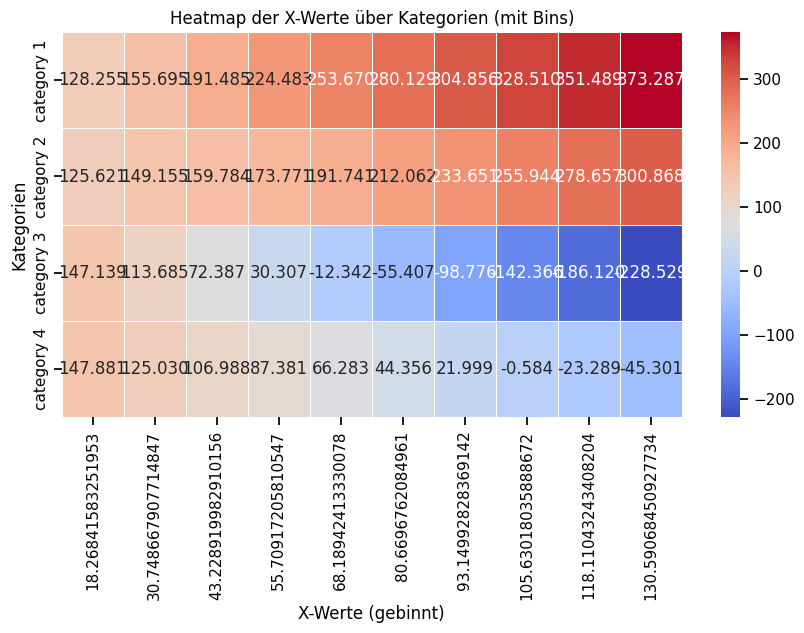

In [ ]:
import seaborn as sns

shape_fun = model.get_it_shape_functions_as_dict(scaler=scaler, y_mean=y_mean, y_std=y_std)
data = shape_fun
# Anzahl der Bins definieren
num_bins = 10

# Bins erstellen
bins = np.linspace(min(unique_x_values), max(unique_x_values), num_bins + 1)

# Kategorien erfassen
categories = [category['name'] for category in data]

# Heatmap-Matrix initialisieren
heatmap_data_binned = np.full((len(categories), num_bins), np.nan)

# Daten in die Bins einteilen und aggregieren (Mittelwert innerhalb jedes Bins)
for i, category in enumerate(data):
    for x_val, y_val in zip(category['x'], category['y']):
        bin_index = np.digitize(x_val, bins) - 1  # Bin-Index bestimmen
        if 0 <= bin_index < num_bins:
            if np.isnan(heatmap_data_binned[i, bin_index]):
                heatmap_data_binned[i, bin_index] = y_val
            else:
                heatmap_data_binned[i, bin_index] = (heatmap_data_binned[i, bin_index] + y_val) / 2

# Bin-Mittelpunkte als neue X-Werte
bin_labels = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

# DataFrame für die Heatmap erstellen
df_heatmap_binned = pd.DataFrame(heatmap_data_binned, index=categories, columns=bin_labels)

# Heatmap plotten
plt.figure(figsize=(10, 5))
sns.heatmap(df_heatmap_binned, cmap="coolwarm", annot=True, fmt=".3f", linewidths=0.5)

# Achsentitel setzen
plt.xlabel("X-Werte (gebinnt)")
plt.ylabel("Kategorien")
plt.title("Heatmap der X-Werte über Kategorien (mit Bins)")

# Anzeige der Heatmap
plt.show()


# 6. Regression - Synthetic Health Care Insurance Dataset

In [ ]:
# Set random seed for reproducibility
np.random.seed(1)

# Number of samples
n_samples = 10000

# Generate numeric variables
alter = np.random.randint(18, 90, n_samples)  # Age in years
bmi = np.random.uniform(18, 40, n_samples)  # BMI between 18 and 40

# Generate categorical variables
berufe = ["sitzend", "körperlich aktiv", "arbeitslos/Rentner/Student"]
beruf = np.random.choice(berufe, size=n_samples, p=[0.5, 0.3, 0.2])  # Berufskategorien mit Wahrscheinlichkeiten

chronische_erkrankung = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])  # 30% haben eine chronische Krankheit
chronische_erkrankung = pd.Categorical(chronische_erkrankung)

arztbesuche = np.zeros(n_samples)
for i in range(n_samples):
    if alter[i] < 50:  # Junge Erwachsene (weniger Arztbesuche)
        arztbesuche[i] = np.random.poisson(2)  # 1-3 Arztbesuche
    elif 50 <= alter[i] < 70:  # Mittleres Alter (mehr Arztbesuche)
        arztbesuche[i] = np.random.poisson(5)  # 3-7 Arztbesuche
    else:  # Senioren (häufige Arztbesuche)
        arztbesuche[i] = np.random.poisson(8)  # 6-10 Arztbesuche
    
    # Zusätzliche Besuche für chronisch Kranke
    if chronische_erkrankung[i] == 1:
        arztbesuche[i] += np.random.randint(3, 10)  # Extra 3-10 Arztbesuche
arztbesuche = np.maximum(arztbesuche, 1)

# Interaction effect: Alter x Beruf
interaktion = np.zeros(n_samples)
for cat, factor in zip(["sitzend", "arbeitslos/Rentner/Student", "körperlich aktiv"], [0.1, 0.2, 0.4]):
    interaktion[beruf == cat] = alter[beruf == cat] * factor  # Alter hat stärkeren Effekt in körperlichen Berufen

# Generate target variable (Krankheitskosten in €)
y = (
    alter * 20 +                 # Linearer Effekt des Alters
    ((bmi - 24) ** 2) * 15 +              # Quadratischer Einfluss des BMI (Kosten steigen bei niedrigen & hohen Werten)
    arztbesuche * 200 +          # Mehr Arztbesuche erhöhen Kosten
    (chronische_erkrankung.astype(int) * 5000) +  # Chronische Krankheiten erhöhen die Kosten deutlich
    interaktion * 2000 +                # Interaktionseffekt zwischen Alter und Beruf
    np.random.normal(0, 1000, n_samples)  # Zufälliges Rauschen für Realismus
)

# Combine into a DataFrame
X = pd.DataFrame({
    "Alter": alter,
    "BMI": bmi,
    "Anzahl Arztbesuche Vorjahr": arztbesuche,
    "Beruf": beruf,
    "Chronische Erkrankung": chronische_erkrankung
    })

X.head()

,Alter,BMI,Anzahl Arztbesuche Vorjahr,Beruf,Chronische Erkrankung
0,55,20.583860,8.0,sitzend,0
1,30,18.274433,1.0,körperlich aktiv,0
2,27,21.195348,2.0,sitzend,0
3,23,33.655623,1.0,arbeitslos/Rentner/Student,0
4,82,26.902419,16.0,körperlich aktiv,1


In [ ]:
# scale data
scaler = StandardScaler()
continuous_features = sorted(['Alter', 'BMI', 'Anzahl Arztbesuche Vorjahr'])
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [ ]:
model.fit(X, y)

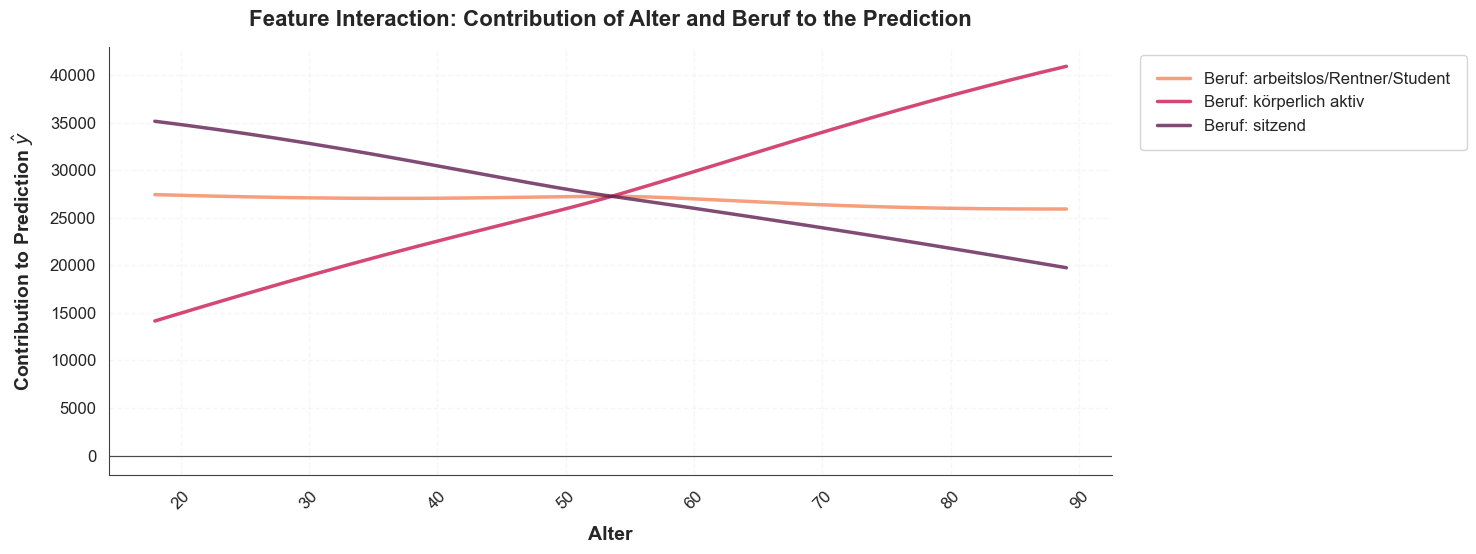

In [ ]:
model.plot_it(scaler=scaler, y_mean=y_mean, y_std=y_std, include_univariate=False)

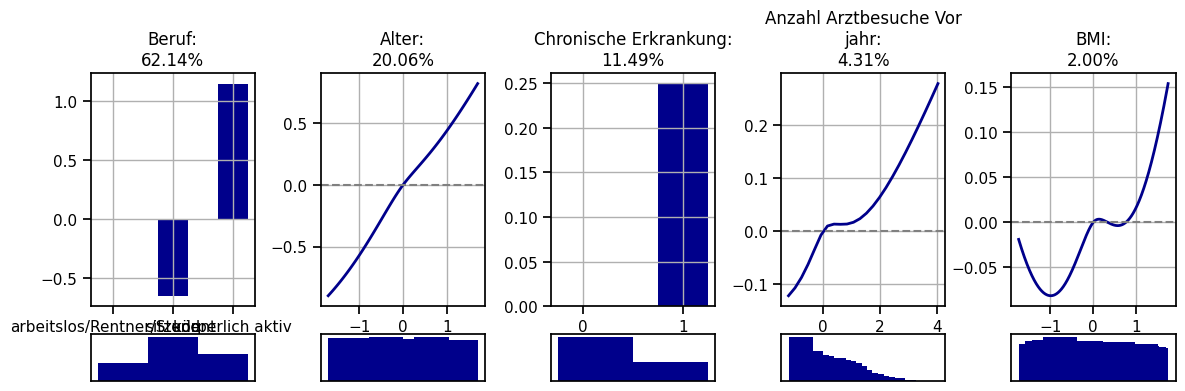

In [ ]:
model.plot_single()

# 7. Classification - Synthetic Car Insurance Dataset

In [ ]:
np.random.seed(1)

num_samples = 5000

fahrleistung = np.random.randint(5000, 50000, num_samples)  # Annual mileage in km
fahrzeugtyp = np.random.choice(["Kleinwagen", "SUV", "Sportwagen", "Transporter"], num_samples)
alter_fahrer = np.random.randint(18, 80, num_samples)  # Age of driver
anzahl_unfälle = np.random.poisson(0.5, num_samples)  # Previous accidents (Poisson distribution)
region = np.random.choice(["ländlich", "städtisch", "Metropole"], num_samples)

# Define probability of an accident based on features
base_prob = 0.02  # Base probability of accident

# Interaction effect: Higher mileage increases risk for Sportwagen & Transporter more
prob_fahrleistung = (fahrleistung / 50000) * 0.05  # Scaling mileage effect

# Different effects for vehicle types
fahrzeugtyp_effect = np.array([
    0.01 if t == "Kleinwagen" else
    0.03 if t == "SUV" else
    0.07 if t == "Sportwagen" else
    0.05 for t in fahrzeugtyp
])

# Age effect: Younger and older drivers have higher risk
alter_effect = np.where((alter_fahrer < 25) | (alter_fahrer > 65), 0.05, 0.02)

# More past accidents -> higher probability
unfall_effect = anzahl_unfälle * 0.04

# Regional effect: More accidents in cities & metropolitan areas
region_effect = np.array([
    0.01 if r == "ländlich" else
    0.03 if r == "städtisch" else
    0.05 for r in region
])

# Compute final probability (capped at 1)
final_prob = np.clip(base_prob + prob_fahrleistung + fahrzeugtyp_effect + alter_effect + unfall_effect + region_effect, 0, 1)

# Generate binary target variable (1 = accident, 0 = no accident) using probabilities
y = np.random.binomial(1, final_prob, num_samples)

# Create DataFrame
X = pd.DataFrame({
    "Jährliche Fahrleistung (km)": fahrleistung,
    "Fahrzeugtyp": fahrzeugtyp,
    "Alter Fahrer": alter_fahrer,
    "Anzahl früherer Unfälle": anzahl_unfälle,
    "Region": region
    })

In [ ]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X = data.drop(columns="Unfall")
y = data["Unfall"]

In [ ]:
# scale data
scaler = StandardScaler()
continuous_features = sorted(['Jährliche Fahrleistung (km)', 'Alter Fahrer', 'Anzahl früherer Unfälle'])
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

In [ ]:
model = IGANN(task='classification', n_hid=10, interaction_detection_method='dt')

In [ ]:
model.fit(X, y)

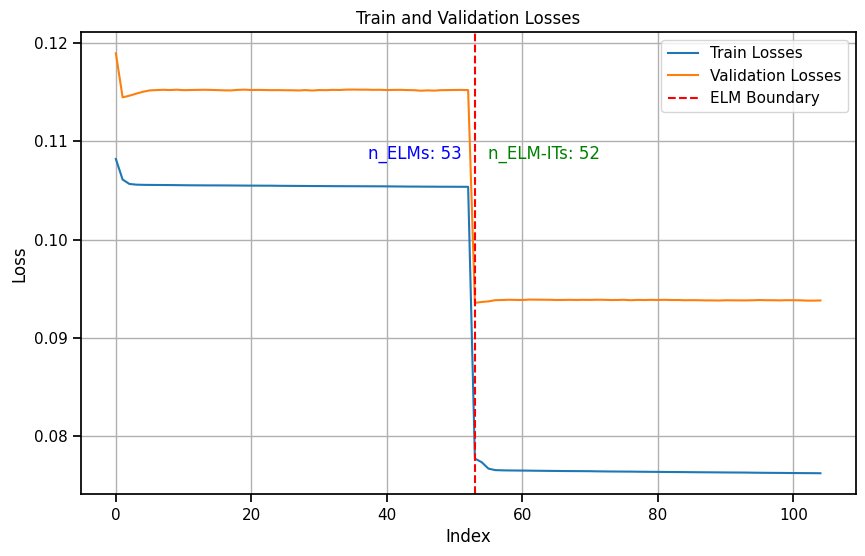

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses+model.train_losses_it, label="Train Losses")
plt.plot(model.val_losses+model.val_losses_it, label="Validation Losses")
plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len(model.train_losses_it)), horizontalalignment='left', color="green", fontsize=12)
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Train and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definiere Features und Zielvariable
X = df.drop(columns=["Unfall aufgetreten"])  # Features
y = df["Unfall aufgetreten"]  # Zielvariable

# Identifiziere numerische und kategorische Features
numerical_features = ["Jährliche Fahrleistung (km)", "Alter Fahrer", "Anzahl früherer Unfälle"]
categorical_features = ["Fahrzeugtyp", "Region"]

# Preprocessing: Skalierung für numerische, One-Hot-Encoding für kategorische Variablen
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Erstelle Pipeline mit Logistischer Regression
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trainiere das Modell
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Bewertung des Modells
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Ergebnisse anzeigen
accuracy, classification_rep, conf_matrix


(0.802,
 '              precision    recall  f1-score   support\n\n           0       0.80      1.00      0.89       803\n           1       0.00      0.00      0.00       197\n\n    accuracy                           0.80      1000\n   macro avg       0.40      0.50      0.45      1000\nweighted avg       0.64      0.80      0.71      1000\n',
 array([[802,   1],
        [197,   0]]))

# 8. Regression - Synthetic Car Insurance

In [ ]:
np.random.seed(42)
n_samples = 1000

# Kategorische Variablen
car_type = np.random.choice(["Sedan", "SUV", "Truck", "Electric", "Luxury"], size=n_samples)
age = np.random.randint(18, 80, size=n_samples)
age_effect = 1 + 0.002 * (age - 50) ** 2

# Numerische Variablen
mileage = np.random.uniform(5000, 200000, size=n_samples)  # Jahreskilometerleistung
accidents = np.random.poisson(lam=0.5, size=n_samples)  # Anzahl der Unfälle

interaction_effect = np.where(
    ((car_type == "Truck") & (mileage > 120000)), 1.4,  # Trucks with high mileage pay 40% more
    np.where(((car_type == "SUV") & (mileage > 120000)), 1.2,  # SUVs with high mileage pay 20% more
    np.where(((car_type == "Luxury") & (mileage > 120000)), 2,  # Luxury cars with high mileage pay 50% more
    np.where((car_type == "Electric"), 1.1,  # EVs with very high mileage pay 10% more
    1.0  # Default case (no increased risk)
))))

# Versicherungsleistung (in Euro) = Basiswert + Einfluss der Variablen + Interaktionseffekt
base_payout = 500  # Basiswert für alle Verträge
y = base_payout * interaction_effect + (mileage * 0.005) *interaction_effect * 0.5 + (accidents * 100) * 0.5  * age_effect + np.random.normal(loc=0, scale=100, size=n_samples)

# Daten in DataFrame speichern
X = pd.DataFrame({
    "carType": car_type,
    "age": age,
    "mileage": mileage,
    "accidents": accidents
})

In [ ]:
X.head()

,carType,age,mileage,accidents
0,Electric,29,99457.697277,1
1,Luxury,61,133859.923068,0
2,Truck,53,112835.283255,1
3,Luxury,65,121507.793213,0
4,Luxury,21,157847.347917,1


In [ ]:
# scale data
scaler = StandardScaler()
continuous_features = sorted(['mileage', 'accidents', 'age'])
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [ ]:
model.fit(X, y)

In [ ]:
shape_fun = model.get_it_shape_functions_as_dict(scaler=scaler, y_mean=0, y_std=y_std)

In [ ]:
shape_fun

[{'name': 'category 1',
  'x': [5036.7421875,
   5685.84375,
   6334.9453125,
   6984.0546875,
   7633.15625,
   8282.2578125,
   8931.3671875,
   9580.46875,
   10229.5703125,
   10878.671875,
   11527.78125,
   12176.8828125,
   12825.984375,
   13475.0859375,
   14124.1875,
   14773.296875,
   15422.3984375,
   16071.5078125,
   16720.609375,
   17369.7109375,
   18018.8125,
   18667.9140625,
   19317.015625,
   19966.125,
   20615.234375,
   21264.328125,
   21913.4375,
   22562.5390625,
   23211.640625,
   23860.7421875,
   24509.8515625,
   25158.953125,
   25808.0546875,
   26457.15625,
   27106.2578125,
   27755.3671875,
   28404.4765625,
   29053.578125,
   29702.6796875,
   30351.78125,
   31000.8828125,
   31649.984375,
   32299.09375,
   32948.1953125,
   33597.3046875,
   34246.3984375,
   34895.5078125,
   35544.609375,
   36193.71484375,
   36842.81640625,
   37491.91796875,
   38141.0234375,
   38790.125,
   39439.234375,
   40088.33203125,
   40737.44140625,
   41386.5

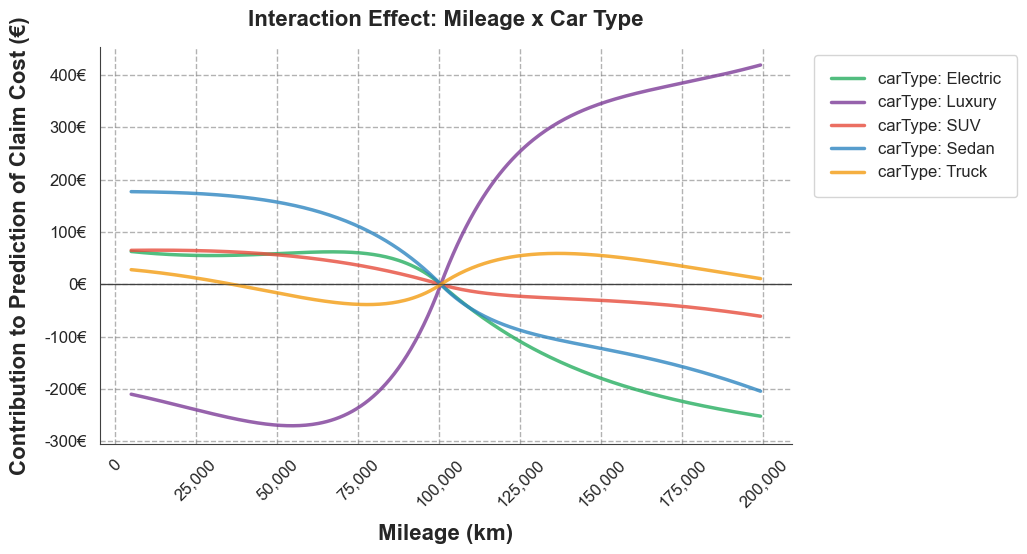

In [ ]:
model.plot_it(scaler=scaler, y_mean=0, y_std=y_std, include_univariate=False)

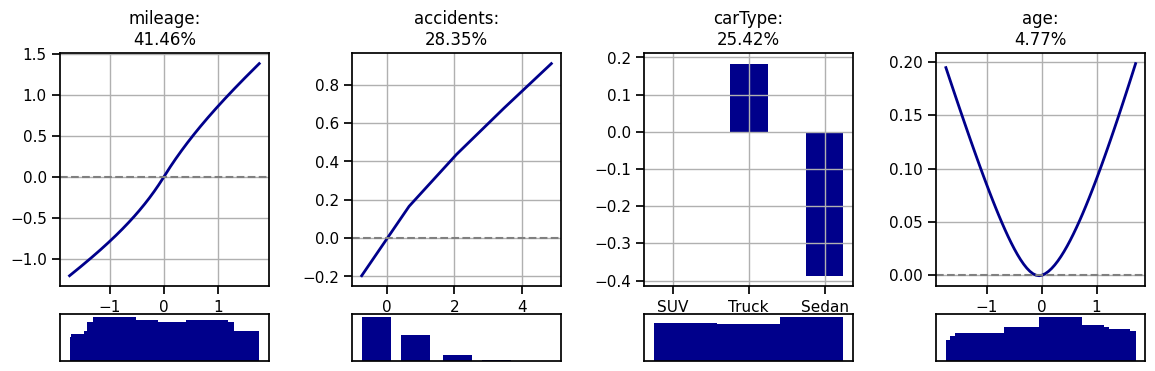

In [ ]:
model.plot_single()

In [ ]:
data_dict = model.get_shape_functions_as_dict()

In [ ]:
X

,accidents,age,mileage,carType
0,0.652157,-1.135572,-0.019251,Electric
1,-0.741341,0.682434,0.603880,Luxury
2,0.652157,0.227933,0.223059,Truck
3,-0.741341,0.909685,0.380144,Luxury
4,0.652157,-1.590074,1.038366,Luxury
...,...,...,...,...
995,-0.741341,1.705063,-0.748889,SUV
996,-0.741341,-0.681071,1.154392,Sedan
997,0.652157,1.705063,-0.725082,Sedan
998,-0.741341,0.852872,1.159777,Electric


In [ ]:
# erstelle eine X_test mit 0 accidents, age 50, mileage 100000, carType SUV
X_test = pd.DataFrame({
    "carType": ["SUV"],
    "age": [50],
    "mileage": [100000],
    "accidents": [4]
})

continuous_features = sorted(['mileage', 'accidents', 'age'])
X_num = scaler.transform(X_test[continuous_features])
X_cat = X.drop(columns=continuous_features)
X_test = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

In [ ]:
model.predict(X_test)

array([1.0631986,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

In [ ]:
# rescale prediction
model.predict(X_test) * y_std

array([291.93436,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 

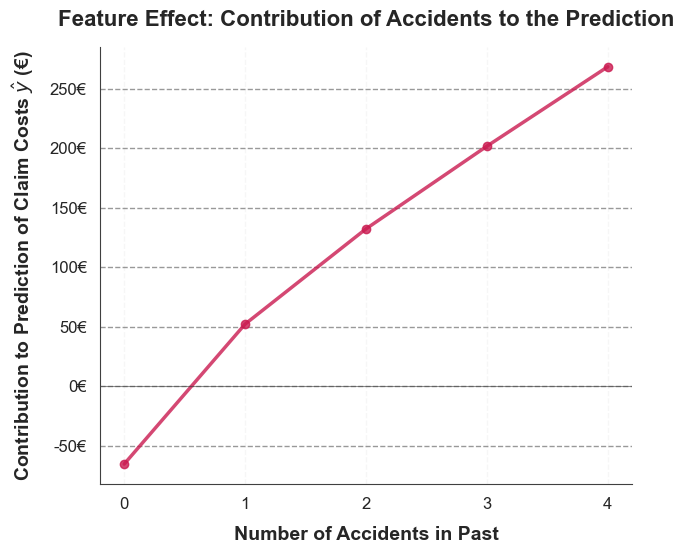

In [ ]:
import matplotlib.ticker as mticker

accidents_data = next(item for item in data_dict if item["name"] == "accidents")

x_raw = accidents_data["x"]
y_raw = accidents_data["y"]

x_accident_mean = scaler.mean_[0]  # Assuming similar naming convention
x_accident_std = scaler.scale_[0]  # Assuming similar naming convention

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, marker="o", label="Effect of Accidents on Claim Cost")

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Number of Accidents in Past", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs $\\hat{y}$ (€)", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_title(
        "Feature Effect: Contribution of Accidents to the Prediction",
        fontsize=16, fontweight="bold", pad=15
    )

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=0, labelsize=12)  # Ensure no rotation
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set X-axis to whole numbers only
    ax.set_xticks([0, 1, 2, 3, 4])

    # Set Y-axis limits
    #ax.set_ylim(600, 1300)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


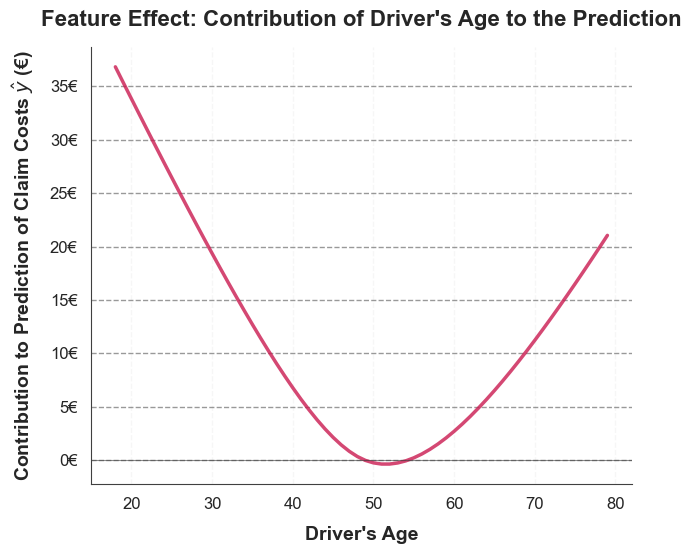

In [ ]:
age_data = next(item for item in data_dict if item["name"] == "age")

x_raw, y_raw = model._get_pred_of_i(1)

x_accident_mean = scaler.mean_[1]  # Assuming similar naming convention
x_accident_std = scaler.scale_[1]  # Assuming similar naming convention

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

import matplotlib.ticker as mticker

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Accidents on Claim Cost")

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Driver's Age", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs $\\hat{y}$ (€)", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_title(
        "Feature Effect: Contribution of Driver's Age to the Prediction",
        fontsize=16, fontweight="bold", pad=15
    )

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=0, labelsize=12)  # Ensure no rotation
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set Y-axis limits
    #ax.set_ylim(700, 950)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


In [ ]:
age_data = next(item for item in data_dict if item["name"] == "mileage")

x_raw, y_raw = model._get_pred_of_i(2)
# x_raw = age_data["x"]
# y_raw = age_data["y"]

x_accident_mean = scaler.mean_[2]  # Assuming similar naming convention
x_accident_std = scaler.scale_[2]  # Assuming similar naming convention

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

import matplotlib.ticker as mticker

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Accidents on Claim Cost")

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Annual Mileage (km)", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs $\\hat{y}$ (€)", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_title(
        "Feature Effect: Contribution of Mileage to the Prediction",
        fontsize=16, fontweight="bold", pad=15
    )

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=45, labelsize=12, direction='in', length=6, width=1.2)  # Rotate and add tick marks
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set Y-axis limits
    #ax.set_ylim(600, 1300)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='-', alpha=0.8, color="gray")
    ax.xaxis.grid(True, linestyle='--', alpha=0.8, color="gray")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.tick_params(axis='x', which='minor', length=4, width=1, color='gray')


    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


NameError: name 'data_dict' is not defined

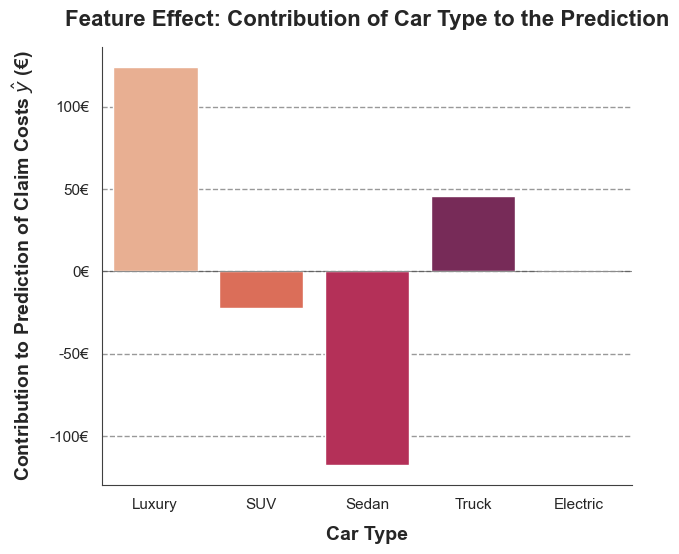

In [ ]:
import pandas as pd

# Extracting 'carType' data
car_type_data = next(item for item in data_dict if item["name"] == "carType")

# Extracting values
categories = car_type_data["x"]
y_values = car_type_data["y"]

# Rescaling y-values
y_rescaled = np.array(y_values) * y_std #+ y_mean

# Creating DataFrame for plotting
df_car_type = pd.DataFrame({"Car Type": categories, "Contribution to Claim Cost (€)": y_rescaled})

# Plotting the Barplot
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=len(categories))

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Create Barplot
    sns.barplot(x="Car Type", y="Contribution to Claim Cost (€)", hue="Car Type", data=df_car_type, palette=color, ax=ax, legend=False)

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Car Type", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs $\\hat{y}$ (€)", fontsize=14, labelpad=10, fontweight='semibold')
    ax.set_title(
        "Feature Effect: Contribution of Car Type to the Prediction",
        fontsize=16, fontweight="bold", pad=15
    )

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".") + "€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


# XXX. Ursprüngliches IGANN laden

In [ ]:
# import sys
# import importlib

# # 🛠 1️⃣ Lösche alle Einträge aus sys.modules, die mit "igann" beginnen
# modules_to_delete = [m for m in sys.modules if m.startswith("igann")]
# for module in modules_to_delete:
#     del sys.modules[module]

# # 🛠 2️⃣ Entferne den alten Pfad sicherheitshalber (falls er noch in `sys.path` ist)
# sys.path = [p for p in sys.path if "masterarbeit/igann-it" not in p]

# # 🛠 3️⃣ Füge den neuen Pfad hinzu
# sys.path.insert(0, "/Users/max/workspace/master/igann")

# # 🛠 4️⃣ Importiere das neue `igann`-Modul
# import igann
# importlib.reload(igann)

# # ✅ 5️⃣ Überprüfen, ob das richtige `igann`-Modul geladen wurde
# print("Aktuelles igann-Modul geladen aus:", igann.__file__)

# # 🛠 6️⃣ Teste den neuen Import
# from igann import IGANN
# model = IGANN(task='classification', n_hid=10)

# # 🛠 7️⃣ Teste das Training mit den neuen Einstellungen
# model.fit(X, y)  # Sollte jetzt das richtige `igann` verwenden!

Aktuelles igann-Modul geladen aus: /Users/maximilianveitl/workspace/master/igann/igann/__init__.py


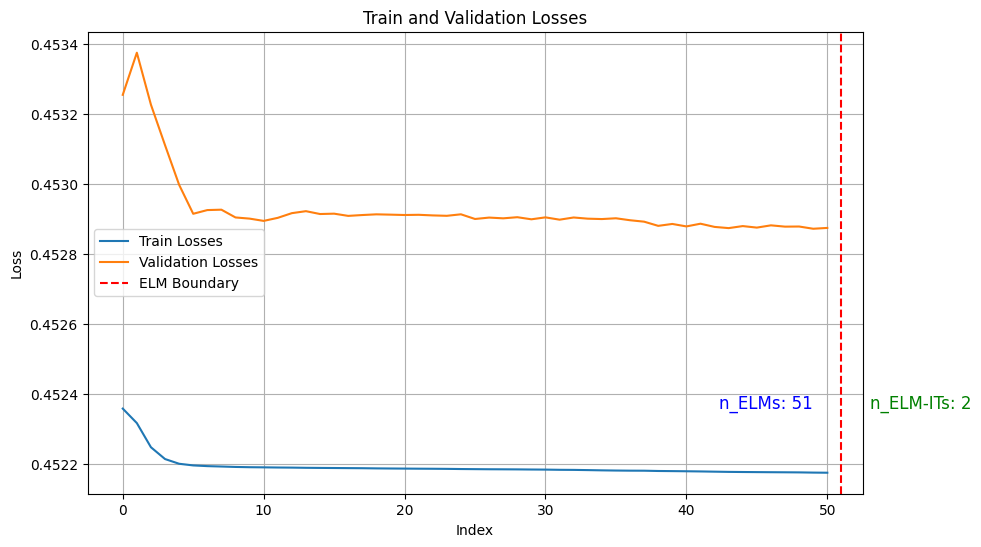

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(model.train_losses, label="Train Losses")
# plt.plot(model.val_losses, label="Validation Losses")
# plt.axvline(x=len(model.train_losses), color="red", linestyle="--", label="ELM Boundary")
# plt.text(len(model.train_losses) - 2, max(model.train_losses), "n_ELMs: "+str(len(model.train_losses)), horizontalalignment='right', color="blue", fontsize=12)
# plt.text(len(model.train_losses) + 2, max(model.train_losses), "n_ELM-ITs: "+str(len([0,1])), horizontalalignment='left', color="green", fontsize=12)
# plt.xlabel("Index")
# plt.ylabel("Loss")
# plt.title("Train and Validation Losses")
# plt.legend()
# plt.grid(True)
# plt.show()

# X. RuleFit Playground

In [ ]:
from sklearn.ensemble import BaggingRegressor, BaggingClassifier

In [ ]:
y

0       0.347154
1       0.007286
2       0.535970
3      -0.515105
4       0.869545
          ...   
1455   -0.074534
1456    0.366036
1457    1.077242
1458   -0.488356
1459   -0.420697
Name: SalePrice, Length: 1460, dtype: float64

In [ ]:
X

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood,BldgType,HouseStyle,CentralAir,ExterQual
0,-0.207142,0.651479,1.050994,-0.793434,0.370333,CollgCr,1Fam,2Story,Y,Gd
1,-0.091886,-0.071836,0.156734,0.257140,-0.482512,Veenker,1Fam,1Story,Y,TA
2,0.073480,0.651479,0.984752,-0.627826,0.515013,CollgCr,1Fam,2Story,Y,Gd
3,-0.096897,0.651479,-1.863632,-0.521734,0.383659,Crawfor,1Fam,2Story,Y,TA
4,0.375148,1.374795,0.951632,-0.045611,1.299326,NoRidge,1Fam,2Story,Y,Gd
...,...,...,...,...,...,...,...,...,...,...
1455,-0.260560,-0.071836,0.918511,-0.542435,0.250402,Gilbert,1Fam,2Story,Y,TA
1456,0.266407,-0.071836,0.222975,2.355701,1.061367,NWAmes,1Fam,1Story,Y,TA
1457,-0.147810,0.651479,-1.002492,0.065656,1.569647,Crawfor,1Fam,2Story,Y,Ex
1458,-0.080160,-0.795151,-0.704406,-0.218982,-0.832788,NAmes,1Fam,1Story,Y,TA


In [ ]:
# one-hot encoding
X_rulefit = pd.get_dummies(X, columns=['Neighborhood', 'BldgType', 'HouseStyle', 'CentralAir', 'ExterQual'], drop_first=True)
X_rulefit.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,CentralAir_Y,ExterQual_Fa,ExterQual_Gd,ExterQual_TA
0,-0.207142,0.651479,1.050994,-0.793434,0.370333,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
1,-0.091886,-0.071836,0.156734,0.257140,-0.482512,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,True
2,0.073480,0.651479,0.984752,-0.627826,0.515013,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
3,-0.096897,0.651479,-1.863632,-0.521734,0.383659,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
4,0.375148,1.374795,0.951632,-0.045611,1.299326,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False


In [ ]:
base_tree = DecisionTreeRegressor(random_state=42, max_leaf_nodes=6)

bagger = BaggingRegressor(
    estimator=base_tree,
    n_estimators=1, # normal 100
    max_samples=0.5,
    bootstrap=True,
    random_state=42,
)

bagger.fit(X_rulefit, y)


BaggingRegressor(estimator=DecisionTreeRegressor(max_leaf_nodes=6,
                                                 random_state=42),
                 max_samples=0.5, n_estimators=1, random_state=42)

In [ ]:
X.shape

(1460, 10)

In [ ]:
rul = model._top_rulefit_interaction(X_rulefit, y, n_trees=2)

In [ ]:
X_rulefit.head()

,LotArea,OverallQual,YearBuilt,1stFlrSF,GrLivArea,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,CentralAir_Y,ExterQual_Fa,ExterQual_Gd,ExterQual_TA
0,-0.207142,0.651479,1.050994,-0.793434,0.370333,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
1,-0.091886,-0.071836,0.156734,0.257140,-0.482512,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,True
2,0.073480,0.651479,0.984752,-0.627826,0.515013,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
3,-0.096897,0.651479,-1.863632,-0.521734,0.383659,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
4,0.375148,1.374795,0.951632,-0.045611,1.299326,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False


In [ ]:
for k, rule in enumerate(rul):
    print(f"Rule {k+1}:")
    print(rule)    
    for feature, op, threshold in rule['conditions']:
        print(f"Feature {feature} {op} {threshold}")

Rule 1:
{'conditions': [(1, '<=', 0.2898215651512146), (4, '<=', -0.6662163436412811)], 'support': 0.27208480565371024}
Feature 1 <= 0.2898215651512146
Feature 4 <= -0.6662163436412811
Rule 2:
{'conditions': [(1, '<=', 0.2898215651512146), (4, '>', -0.6662163436412811)], 'support': 0.37985865724381623}
Feature 1 <= 0.2898215651512146
Feature 4 > -0.6662163436412811
Rule 3:
{'conditions': [(1, '>', 0.2898215651512146), (1, '<=', 1.7364522814750671), (4, '<=', 0.5188199132680893)], 'support': 0.1696113074204947}
Feature 1 > 0.2898215651512146
Feature 1 <= 1.7364522814750671
Feature 4 <= 0.5188199132680893
Rule 4:
{'conditions': [(1, '>', 0.2898215651512146), (1, '<=', 1.7364522814750671), (4, '>', 0.5188199132680893)], 'support': 0.14664310954063603}
Feature 1 > 0.2898215651512146
Feature 1 <= 1.7364522814750671
Feature 4 > 0.5188199132680893
Rule 5:
{'conditions': [(1, '>', 0.2898215651512146), (1, '>', 1.7364522814750671), (2, '<=', 0.852269321680069)], 'support': 0.00530035335689046}


[Text(0.4444444444444444, 0.9, 'x[1] <= 0.29\nsquared_error = 0.87\nsamples = 570\nvalue = -0.04'),
 Text(0.2222222222222222, 0.7, 'x[4] <= 0.039\nsquared_error = 0.237\nsamples = 345\nvalue = -0.53'),
 Text(0.3333333333333333, 0.8, 'True  '),
 Text(0.1111111111111111, 0.5, 'squared_error = 0.132\nsamples = 258\nvalue = -0.697'),
 Text(0.3333333333333333, 0.5, 'squared_error = 0.237\nsamples = 87\nvalue = -0.07'),
 Text(0.6666666666666666, 0.7, 'x[1] <= 1.013\nsquared_error = 0.868\nsamples = 225\nvalue = 0.765'),
 Text(0.5555555555555556, 0.8, '  False'),
 Text(0.5555555555555556, 0.5, 'squared_error = 0.314\nsamples = 134\nvalue = 0.327'),
 Text(0.7777777777777778, 0.5, 'x[4] <= 0.771\nsquared_error = 0.982\nsamples = 91\nvalue = 1.417'),
 Text(0.6666666666666666, 0.3, 'x[3] <= 1.022\nsquared_error = 0.636\nsamples = 49\nvalue = 0.899'),
 Text(0.5555555555555556, 0.1, 'squared_error = 0.122\nsamples = 21\nvalue = 0.286'),
 Text(0.7777777777777778, 0.1, 'squared_error = 0.526\nsamples

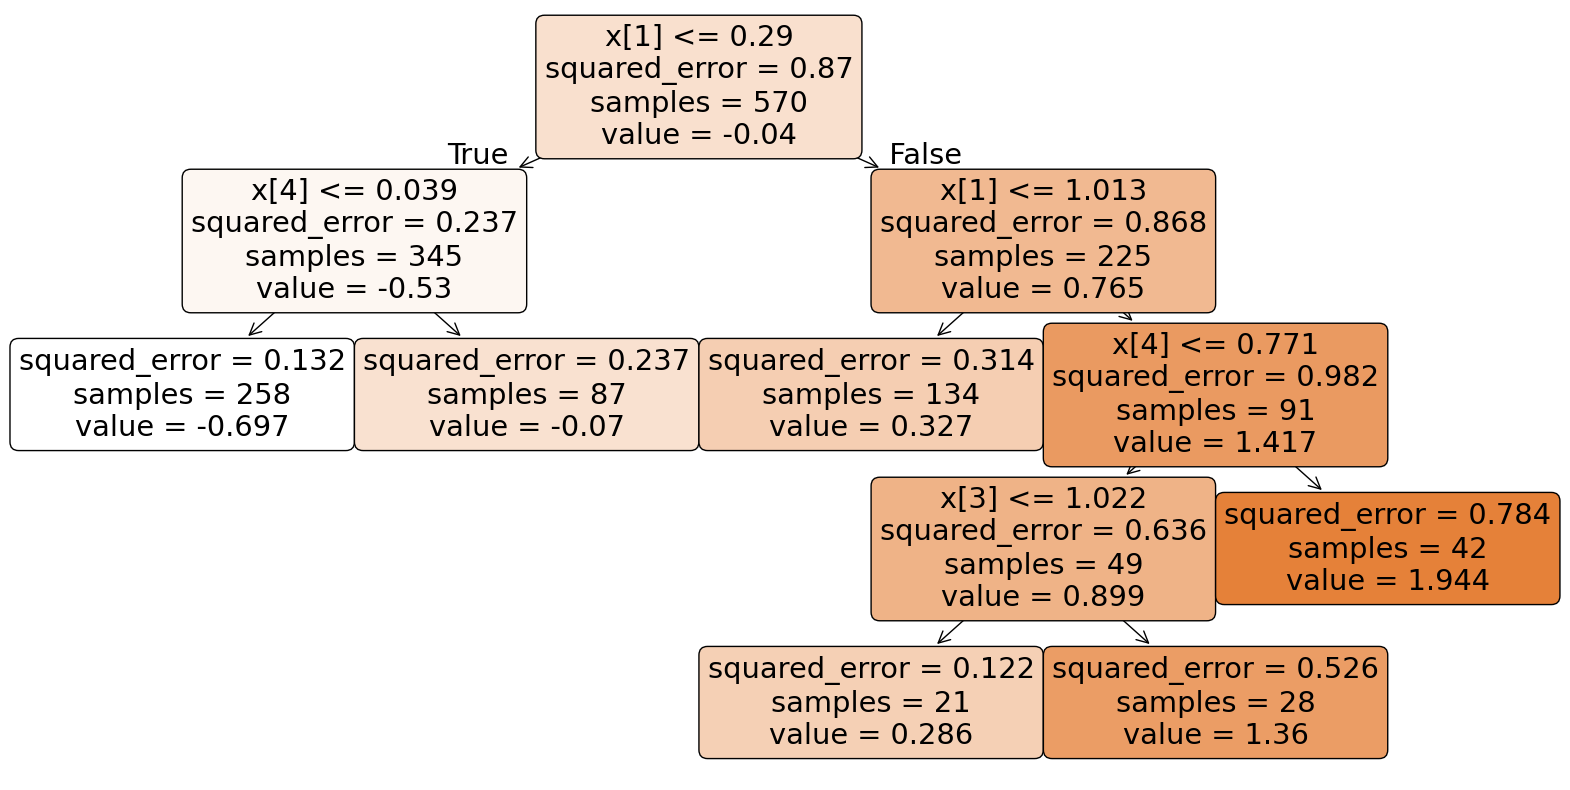

In [ ]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(bagger.estimators_[0], filled=True, rounded=True)

In [ ]:
bagger.estimators_[0].tree_.children_left

array([ 1,  5,  3, -1,  7, -1, -1,  9, -1, -1, -1], dtype=int64)